# Hidden Markov Models
## Robot Localisation
The objective of this notebook is to apply Hidden Markov Models (HMM) to localization problem and determine most likely path followed by robot to reach current location.

In [37]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt

##### Global variables

In [38]:
# Shape of the robot grid
X = 4
Y = 16

# The grid of the robot (0: obstacle, 1: free square)
grid = np.ones((X, Y))
# Obstacles - Count = 22
# X = 0, Y = 0 is the top left corner
grid[0][4] = 0
grid[0][10] = 0
grid[0][14] = 0
grid[1][0] = 0
grid[1][1] = 0
grid[1][4] = 0
grid[1][6] = 0
grid[1][7] = 0
grid[1][9] = 0
grid[1][11] = 0
grid[1][13] = 0
grid[1][14] = 0
grid[1][15] = 0
grid[2][0] = 0
grid[2][4] = 0
grid[2][6] = 0
grid[2][7] = 0
grid[2][13] = 0
grid[2][14] = 0
grid[3][2] = 0
grid[3][6] = 0
grid[3][11] = 0

In [39]:
# List of all free squares
free_squares = []

# Free squares means grid[i][j] = 1, i.e., robot can move to that square
for i in range(X):
    for j in range(Y):
        if grid[i][j] == 1:
            free_squares.append((i, j))

# Number of free squares
num_free_squares = len(free_squares)

##### Transition Model

In [40]:
# Funtion to get free neighbours of a square
def get_neighbours(i, j):
    neighbours = []
    
    # Check North square
    if i > 0 and grid[i - 1][j] == 1:
        neighbours.append((i - 1, j))
    # Check South square
    if i < X - 1 and grid[i + 1][j] == 1:
        neighbours.append((i + 1, j))
    # Check West square
    if j > 0 and grid[i][j - 1] == 1:
        neighbours.append((i, j - 1))
    # Check East square
    if j < Y - 1 and grid[i][j + 1] == 1:
        neighbours.append((i, j + 1))
    
    return neighbours

# Calculate the transition matrix using the formula given in the question
def calculate_transition_matrix():
    # Transition matrix
    transition_matrix = np.zeros([num_free_squares, num_free_squares])
    
    # For each free square
    for i in range(num_free_squares):
        (x, y) = free_squares[i]
        
        # Get the neighbours of the square
        neighbours = get_neighbours(x, y)
        num_neighbours = len(neighbours)
        
        # For each neighbour
        for j in range(num_neighbours):
            (x1, y1) = neighbours[j]
            
            # Update the transition matrix at position (i, k)
            # k is the index of the neighbour in the list of free squares
            k = free_squares.index((x1, y1))
            transition_matrix[i][k] = 1 / num_neighbours
    
    return transition_matrix

##### Sensor Model

In [41]:
# Funtion to get correct sensor reading for a square
def get_correct_sensor_reading(i, j):
    sensor_reading = list("1111")
    # Check North square
    if i > 0 and grid[i - 1][j] == 0:
        sensor_reading[0] = "0"
    # Check South square
    if i < X - 1 and grid[i + 1][j] == 0:
        sensor_reading[1] = "0"
    # Check West square
    if j > 0 and grid[i][j - 1] == 0:
        sensor_reading[2] = "0"
    # Check East square
    if j < Y - 1 and grid[i][j + 1] == 0:
        sensor_reading[3] = "0"
    return sensor_reading

# Funtion to get count of discrepancies in sensor readings
def get_discrepancy_count(sensor_reading1, sensor_reading2):
    discrepancy_count = 0
    for i in range(4):
        # If the sensor readings are different, increment the discrepancy count
        if sensor_reading1[i] != sensor_reading2[i]:
            discrepancy_count += 1
    return discrepancy_count

# Calculate the sensor matrix at time t using the formula given in the question
# pos is the index of the current position in the list of free squares at time t
# epsilon is the probability of sensor error
def calculate_sensor_matrix(pos, epsilon):
    # Sensor matrix
    sensor_matrix = np.zeros([num_free_squares, num_free_squares])
    
    # Get the sensor reading at the current position
    sensor_reading = get_correct_sensor_reading(free_squares[pos][0], free_squares[pos][1])
    
    # Generate error in the sensor reading with probability epsilon
    for i in range(4):
        if np.random.rand() < epsilon:
            sensor_reading[i] = "1" if sensor_reading[i] == "0" else "0"
    
    # For each free square
    for k in range(num_free_squares):
        (x, y) = free_squares[k]
        
        # Get the correct sensor reading for the square
        correct_sensor_reading = get_correct_sensor_reading(x, y)
        
        # Get the discrepancy count between the two sensor readings
        discrepancy_count = get_discrepancy_count(correct_sensor_reading, sensor_reading)
        
        # Calculate the sensor reading probability using the formula given in the question
        sensor_matrix[k][k] = ((1 - epsilon) ** (4 - discrepancy_count)) * (epsilon ** discrepancy_count)
    
    return sensor_matrix

##### Filtering

In [42]:
# Funtion to get next filter state using the filtering step
def filtering_step(filter_t, transition_matrix, sensor_matrix):
    return np.matmul(sensor_matrix, np.matmul(np.transpose(transition_matrix), filter_t))

##### Viterbi Algorithm

In [43]:
# Viterbi Algorithm to find the most likely path
def Viterbi_Algo_step(M_t, transition_matrix, sensor_matrix):
    temp = np.multiply(np.transpose(transition_matrix), M_t)
    
    # Take max of temp along the columns
    t = np.amax(temp, axis = 1)
    next_M = np.matmul(sensor_matrix, t)
    
    # Get most likely square by taking max of next_M
    max_index = np.argmax(next_M)
    return next_M, max_index

##### HMM Algorithm

In [44]:
# Function to implement the HMM algorithm
# epsilon is the probability of sensor error
# num_observations is the number of observations made, i.e., the number of time steps
# num_iters is the number of iterations to run the algorithm and get the average results
def HMM_Algorithm(epsilon, num_observations=50, num_iters=500):
    # Initialize the average error and accuracy arrays
    average_error = np.zeros(num_observations)
    average_accuracy = np.zeros(num_observations)
    
    # Calculate the transition matrix
    transition_matrix = calculate_transition_matrix()
    
    # For each iteration
    for _ in range(num_iters):
        # Initialize the prior probability distribution
        filter_t = np.full([num_free_squares, 1], 1 / num_free_squares)
        M_t = np.full([num_free_squares, 1], 1 / num_free_squares)
        
        # Initialize the actual path, estimated path, error and accuracy arrays
        actual_path = np.zeros(num_observations)
        estimated_path = np.zeros(num_observations)
        error = np.zeros(num_observations)
        accuracy = np.zeros(num_observations)
        
        # Randomly select a free square as the starting position of the robot
        curr_pos = -1
        while True:
            curr_pos = np.random.randint(num_free_squares)
            (i, j) = free_squares[curr_pos]
            neighbours = get_neighbours(i, j)
            # If the starting position has neighbours, select it
            if len(neighbours) > 0:
                break
        
        # For each observation, i.e., at time step t
        for obs in range(num_observations):
            # Move the robot to a random neighbour, for t > 0
            if obs != 0:
                neighbours = get_neighbours(free_squares[curr_pos][0], free_squares[curr_pos][1])
                neighbour_to_move = np.random.randint(0, len(neighbours), size=None)
                curr_pos = free_squares.index(neighbours[neighbour_to_move])
            
            # Calculate the sensor matrix at time t
            sensor_matrix = calculate_sensor_matrix(curr_pos, epsilon)
            
            # Get the most likely square using the filtering step
            filter_t = filtering_step(filter_t, transition_matrix, sensor_matrix)
            max_ind_filter = np.argmax(filter_t)
            
            # Calculate error for the observation
            (a, b) = free_squares[curr_pos]
            (x, y) = free_squares[max_ind_filter]
            error[obs] = abs(a - x) + abs(b - y)
            
            actual_path[obs] = curr_pos
            
            # Get the most likely square using the Viterbi Algorithm
            M_t, estimated_index = Viterbi_Algo_step(M_t, transition_matrix, sensor_matrix)
            estimated_path[obs] = estimated_index
            
            # Calculate path accuracy for all observations till now
            num = 0
            for k in range(obs + 1):
                if estimated_path[k] == actual_path[k]:
                    num += 1
            accuracy[obs] = num / (obs + 1)
        
        # Update the average error and accuracy arrays
        average_error += error
        average_accuracy += accuracy
    
    # Average over all iterations
    average_error /= num_iters
    average_accuracy /= num_iters
    return average_error, average_accuracy

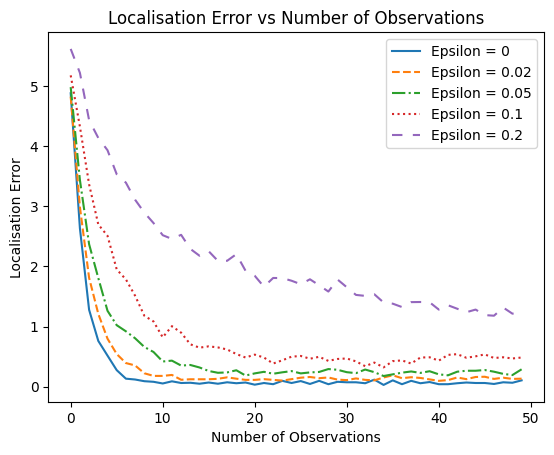

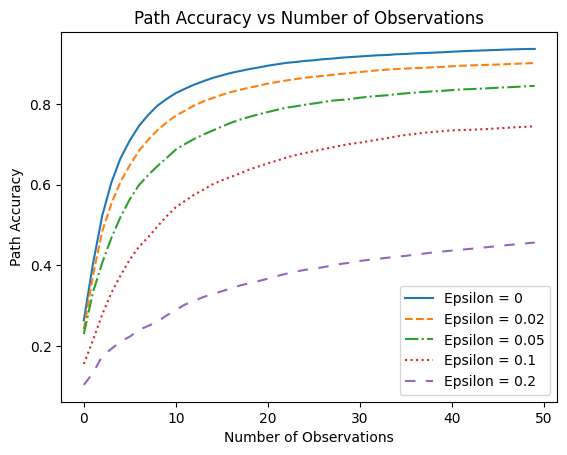

In [45]:
# Different values of epsilon to test
epsilon_s = [0, 0.02, 0.05, 0.1, 0.2]
# Arrays to store the localisation error and path accuracy for different values of epsilon
localisation_error = []
path_accuracy = []

# For each value of epsilon, run the HMM algorithm and store the results
for e in range(len(epsilon_s)):
    average_error, average_accuracy = HMM_Algorithm(epsilon_s[e])
    localisation_error.append(average_error)
    path_accuracy.append(average_accuracy)

# Plot the results
style = ['solid', 'dashed', 'dashdot', 'dotted', (0, (5,5))]

# Localisation Error vs Number of Observations
plt.title("Localisation Error vs Number of Observations")
plt.xlabel("Number of Observations")
plt.ylabel("Localisation Error")
for i in range(len(epsilon_s)):
    plt.plot(localisation_error[i], label = "Epsilon = " + str(epsilon_s[i]), linestyle = style[i])
plt.legend()
plt.show()

# Path Accuracy vs Number of Observations
plt.title("Path Accuracy vs Number of Observations")
plt.xlabel("Number of Observations")
plt.ylabel("Path Accuracy")
for i in range(len(epsilon_s)):
    plt.plot(path_accuracy[i], label = "Epsilon = " + str(epsilon_s[i]), linestyle = style[i])
plt.legend()
plt.show()